In [171]:
!pip install pareto

In [172]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import pareto
import math

In [173]:
dataset = 'ml100k'

## Mejores hiper parámetros

In [174]:
df = {}
for m in ['ResBeMF', 'BeMF', 'DirMF', 'PMF', "MLP"]:
    df[m] = pd.read_csv('results/gridsearch/' + dataset + '/' + m.lower() +'-best.csv')

In [175]:
df['MLP'].sort_values(by=['cummulativemae_avg'], ascending=False)

,cummulativemae_fold_0,cummulativemae_fold_1,cummulativemae_fold_2,cummulativemae_fold_3,cummulativemae_avg,cummulativemae_std,cummulativecoverage_fold_0,cummulativecoverage_fold_1,cummulativecoverage_fold_2,cummulativecoverage_fold_3,cummulativecoverage_avg,cummulativecoverage_std,numEpochs,numFactors,learningRate,seed
22,0.805960,0.803075,0.801756,0.787328,0.799530,0.007207,1.0,1.0,1.0,1.0,1.0,0.0,100,2,0.1000,4815162342
45,0.800686,0.781751,0.776438,0.772985,0.782965,0.010697,1.0,1.0,1.0,1.0,1.0,0.0,75,2,0.1000,4815162342
56,0.780874,0.781690,0.780672,0.779238,0.780619,0.000884,1.0,1.0,1.0,1.0,1.0,0.0,100,2,0.0100,4815162342
61,0.779742,0.777071,0.778672,0.778642,0.778532,0.000953,1.0,1.0,1.0,1.0,1.0,0.0,100,10,0.0100,4815162342
58,0.776670,0.776838,0.778594,0.777448,0.777388,0.000754,1.0,1.0,1.0,1.0,1.0,0.0,100,6,0.0100,4815162342
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11,-0.171685,-0.169516,-0.170057,-0.165018,-0.169069,0.002471,1.0,1.0,1.0,1.0,1.0,0.0,25,4,0.0010,4815162342
95,-0.228567,-0.226264,-0.226825,-0.221838,-0.225874,0.002480,1.0,1.0,1.0,1.0,1.0,0.0,100,4,0.0001,4815162342
73,-0.238178,-0.235861,-0.236427,-0.231448,-0.235479,0.002479,1.0,1.0,1.0,1.0,1.0,0.0,75,4,0.0001,4815162342
68,-0.247895,-0.245570,-0.246137,-0.241169,-0.245193,0.002477,1.0,1.0,1.0,1.0,1.0,0.0,50,4,0.0001,4815162342


In [176]:
df['MLP'].sort_values(by=['cummulativecoverage_avg'], ascending=False)

,cummulativemae_fold_0,cummulativemae_fold_1,cummulativemae_fold_2,cummulativemae_fold_3,cummulativemae_avg,cummulativemae_std,cummulativecoverage_fold_0,cummulativecoverage_fold_1,cummulativecoverage_fold_2,cummulativecoverage_fold_3,cummulativecoverage_avg,cummulativecoverage_std,numEpochs,numFactors,learningRate,seed
0,0.764128,0.763013,0.764719,0.768496,0.765089,0.002060,1.0,1.0,1.0,1.0,1.0,0.0,100,10,0.1000,4815162342
63,0.770205,0.769943,0.771878,0.769849,0.770469,0.000824,1.0,1.0,1.0,1.0,1.0,0.0,75,6,0.0100,4815162342
73,-0.238178,-0.235861,-0.236427,-0.231448,-0.235479,0.002479,1.0,1.0,1.0,1.0,1.0,0.0,75,4,0.0001,4815162342
72,0.764767,0.760904,0.762505,0.760535,0.762178,0.001668,1.0,1.0,1.0,1.0,1.0,0.0,50,2,0.1000,4815162342
71,0.026560,0.028974,0.028682,0.032559,0.029194,0.002155,1.0,1.0,1.0,1.0,1.0,0.0,75,6,0.0001,4815162342
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30,0.270554,0.273604,0.272742,0.277205,0.273526,0.002397,1.0,1.0,1.0,1.0,1.0,0.0,75,10,0.0010,4815162342
29,0.399907,0.398852,0.399685,0.403365,0.400452,0.001727,1.0,1.0,1.0,1.0,1.0,0.0,100,8,0.0010,4815162342
28,0.718220,0.719436,0.721140,0.721315,0.720028,0.001276,1.0,1.0,1.0,1.0,1.0,0.0,25,2,1.0000,4815162342
27,0.358475,0.361377,0.360722,0.365103,0.361419,0.002383,1.0,1.0,1.0,1.0,1.0,0.0,100,10,0.0010,4815162342


## Frente de pareto

In [180]:
df = {}
for m in ['ResBeMF', 'BeMF', 'DirMF', 'PMF', 'MLP']:
    df[m] = pd.read_csv('results/gridsearch/' + dataset + '/' + m.lower() +'.csv')

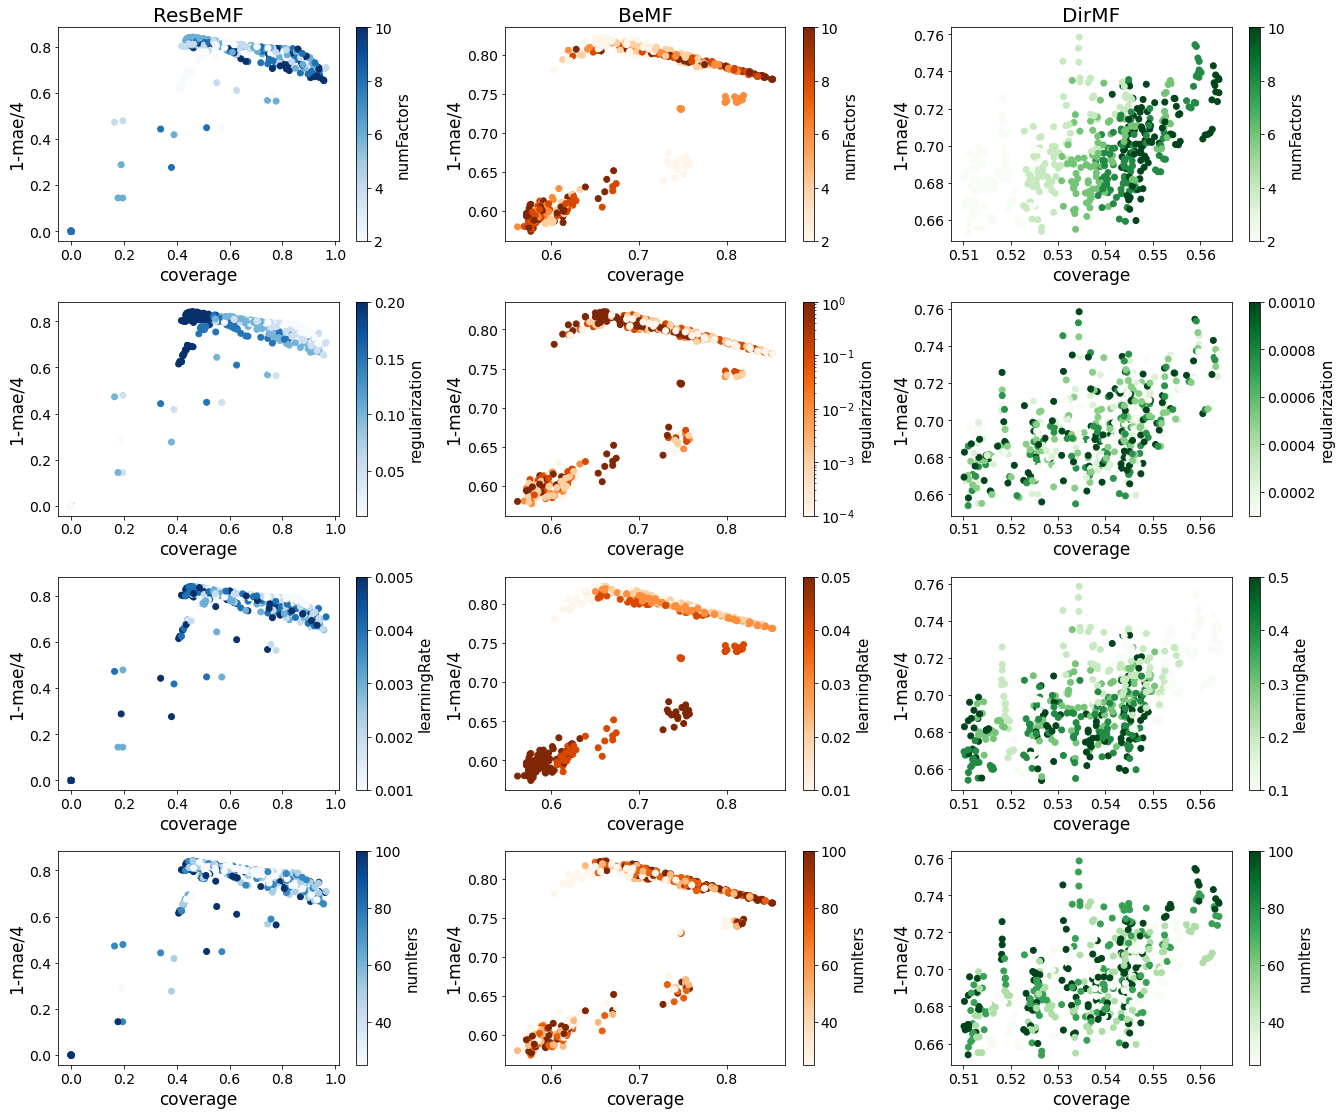

In [181]:
params = ['numFactors', 'regularization', 'learningRate', 'numIters']
methods = ['ResBeMF', 'BeMF', 'DirMF']
cmaps = ['Blues', 'Oranges', 'Greens']

fig, axs = plt.subplots(len(params), len(methods), figsize=(18,15))
fig.tight_layout(h_pad=4, w_pad=6.5)

for i, param in enumerate(params):
    for j, method in enumerate(methods):
        
        axs[i,j].set_xlabel('coverage', fontsize=17)
        axs[i,j].set_ylabel('1-mae/4', fontsize=17)
        
        if i == 0:
            axs[i,j].set_title(method, fontsize=20)
            
        axs[i,j].tick_params(axis='both', which='major', labelsize=14)
            
        mae = df[method]['cummulativemae_avg']
        coverage = df[method]['cummulativecoverage_avg']
        color = df[method][param] 
        
        norm = colors.LogNorm(vmin=color.min(), vmax=color.max()) if method == 'BeMF' and param == 'regularization' else None
    
        im = axs[i,j].scatter(coverage, mae, c=color, cmap=cmaps[j], norm=norm)
        
        cbar = plt.colorbar(im, ax=axs[i,j])
        cbar.set_label(param, fontsize=15)
        cbar.ax.tick_params(labelsize=14)

In [182]:
def get_pareto_front(df):
    objectives = [df.columns.get_loc(c) for c in ['cummulativemae_avg', 'cummulativecoverage_avg'] if c in df]
    nondominated = pareto.eps_sort([list(df.itertuples(False))], objectives, maximize_all=True)
    pareto_front = pd.DataFrame.from_records(nondominated, columns=list(df.columns.values))
    s = sorted(zip(pareto_front['cummulativecoverage_avg'], pareto_front['cummulativemae_avg']))
    cov, mae = [list(tuple) for tuple in zip(*s)]
    return cov, mae

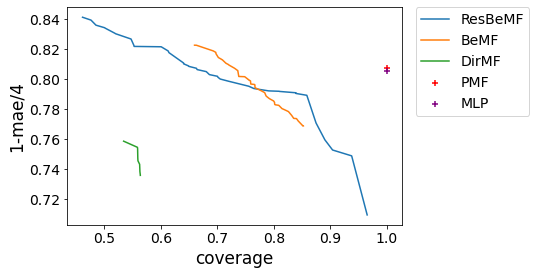

In [183]:
resbemf_coverage, resbemf_mae = get_pareto_front(df['ResBeMF'])
plt.plot(resbemf_coverage, resbemf_mae, label='ResBeMF')

bemf_coverage, bemf_mae = get_pareto_front(df['BeMF'])
plt.plot(bemf_coverage, bemf_mae, label='BeMF')

dirmf_coverage, dirmf_mae = get_pareto_front(df['DirMF'])
plt.plot(dirmf_coverage, dirmf_mae, label='DirMF')

pmf_coverage, pmf_mae = get_pareto_front(df['PMF'])
plt.scatter(pmf_coverage, pmf_mae, label='PMF', c='red', marker='+')

mlp_coverage, mlp_mae = get_pareto_front(df['MLP'])
plt.scatter(mlp_coverage, mlp_mae, label='MLP', c='purple', marker='+')

plt.xlabel('coverage', fontsize=17)
plt.xticks(fontsize=14)

plt.ylabel('1-mae/4', fontsize=17)
plt.yticks(fontsize=14)
    
plt.legend(fontsize=14, loc=(1.04, 0.5))

## Extremos

In [194]:
df['ResBeMF'].sort_values(by=['cummulativecoverage_avg'], ascending=False)

,cummulativemae_fold_0,cummulativemae_fold_1,cummulativemae_fold_2,cummulativemae_fold_3,cummulativemae_fold_4,cummulativemae_avg,cummulativemae_std,cummulativecoverage_fold_0,cummulativecoverage_fold_1,cummulativecoverage_fold_2,cummulativecoverage_fold_3,cummulativecoverage_fold_4,cummulativecoverage_avg,cummulativecoverage_std,numIters,numFactors,learningRate,regularization,scores,seed
446,0.706643,0.703639,0.706817,0.707423,0.721714,0.709247,0.006370,0.968347,0.966338,0.962548,0.962799,0.965488,0.965104,0.002192,50,4,0.004,0.05,[D@3a4afd8d,4815162342
21,0.700595,0.695060,0.705913,0.707860,0.713361,0.704558,0.006264,0.964314,0.961407,0.959627,0.955689,0.964224,0.961052,0.003213,100,4,0.002,0.05,[D@3a4afd8d,4815162342
86,0.658169,0.649011,0.656430,0.644861,0.655852,0.652865,0.005073,0.955355,0.957642,0.958847,0.956549,0.955544,0.956787,0.001313,50,10,0.003,0.05,[D@3a4afd8d,4815162342
391,0.660676,0.656439,0.656935,0.649883,0.656518,0.656090,0.003481,0.952705,0.954430,0.955983,0.955417,0.954921,0.954691,0.001119,75,10,0.002,0.05,[D@3a4afd8d,4815162342
83,0.661930,0.688529,0.672030,0.667091,0.695011,0.676918,0.012707,0.945807,0.940105,0.940965,0.941056,0.938124,0.941211,0.002528,50,8,0.003,0.05,[D@3a4afd8d,4815162342
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,75,8,0.005,0.05,[D@3a4afd8d,4815162342
174,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,75,6,0.005,0.05,[D@3a4afd8d,4815162342
172,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,75,10,0.005,0.05,[D@3a4afd8d,4815162342
169,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50,8,0.005,0.05,[D@3a4afd8d,4815162342


In [191]:
df['MLP'].sort_values(by=['cummulativemae_avg'], ascending=False)

,cummulativemae_fold_0,cummulativemae_fold_1,cummulativemae_fold_2,cummulativemae_fold_3,cummulativemae_fold_4,cummulativemae_avg,cummulativemae_std,cummulativecoverage_fold_0,cummulativecoverage_fold_1,cummulativecoverage_fold_2,cummulativecoverage_fold_3,cummulativecoverage_fold_4,cummulativecoverage_avg,cummulativecoverage_std,numEpochs,numFactors,learningRate,seed
25,0.807650,0.802200,0.804985,0.806159,0.805193,0.805237,0.001787,1.0,1.0,1.0,1.0,1.0,1.0,0.0,100,2,0.10,4815162342
45,0.807136,0.801438,0.804084,0.804571,0.803494,0.804145,0.001838,1.0,1.0,1.0,1.0,1.0,1.0,0.0,75,2,0.10,4815162342
48,0.806091,0.798620,0.801460,0.805984,0.802732,0.802978,0.002831,1.0,1.0,1.0,1.0,1.0,1.0,0.0,50,4,0.10,4815162342
47,0.804252,0.799151,0.800965,0.804223,0.802264,0.802171,0.001956,1.0,1.0,1.0,1.0,1.0,1.0,0.0,75,4,0.10,4815162342
9,0.811025,0.791727,0.803611,0.798010,0.803522,0.801579,0.006433,1.0,1.0,1.0,1.0,1.0,1.0,0.0,100,8,0.10,4815162342
28,0.801415,0.797006,0.798579,0.803419,0.799918,0.800067,0.002221,1.0,1.0,1.0,1.0,1.0,1.0,0.0,100,4,0.10,4815162342
13,0.794044,0.793191,0.791892,0.801223,0.796870,0.795444,0.003319,1.0,1.0,1.0,1.0,1.0,1.0,0.0,100,4,0.01,4815162342
15,0.792271,0.786947,0.787296,0.787863,0.786314,0.788138,0.002126,1.0,1.0,1.0,1.0,1.0,1.0,0.0,100,8,0.01,4815162342
56,0.781510,0.778413,0.782809,0.794375,0.782892,0.784000,0.005435,1.0,1.0,1.0,1.0,1.0,1.0,0.0,25,4,0.10,4815162342
43,0.795933,0.767390,0.791972,0.775337,0.785344,0.783195,0.010540,1.0,1.0,1.0,1.0,1.0,1.0,0.0,75,8,0.10,4815162342


In [208]:
mae_df = pd.read_csv('results/test-split/' + dataset + '/mae.csv')
mae_df

,reliability,ResBeMF_MAE,ResBeMF_Coverage,BeMF_MAE,BeMF_Coverage,DirMF_MAE,DirMF_Coverage,PMF,MLP
0,0.00,0.798280,0.746008,0.799002,0.530319,0.767906,0.766835,0.806067,0.766001
1,0.05,0.798280,0.746008,0.799002,0.530319,0.767906,0.766835,0.806067,0.766001
2,0.15,0.798280,0.746008,0.799002,0.530319,0.767906,0.766835,0.806067,0.766001
3,0.20,0.798280,0.746008,0.799002,0.530319,0.767906,0.766835,0.806067,0.766001
4,0.25,0.808560,0.745297,0.800776,0.535904,0.776750,0.771192,0.806067,0.766001
5,0.30,0.815534,0.747348,0.802737,0.560086,0.799308,0.780813,0.806067,0.766001
6,0.35,0.781666,0.754861,0.810672,0.608708,0.817376,0.795734,0.806067,0.766001
7,0.40,0.882113,0.760718,0.822048,0.608708,0.821046,0.812433,0.806067,0.766001
8,0.45,0.910560,0.762562,0.824537,0.608708,0.766216,0.797755,0.806067,0.766001
9,0.50,0.943590,0.770139,0.837915,0.608708,0.895833,0.804284,0.806067,0.766001


In [209]:
coverage_df = pd.read_csv('results/test-split/' + dataset + '/coverage.csv')
coverage_df

,reliability,ResBeMF_MAE,ResBeMF_Coverage,BeMF_MAE,BeMF_Coverage,DirMF_MAE,DirMF_Coverage,PMF,MLP
0,0.00,1.000000,1.000000,1.000000,0.953809,1.000000,1.000000,1,1
1,0.05,1.000000,1.000000,1.000000,0.953809,1.000000,1.000000,1,1
2,0.15,1.000000,1.000000,1.000000,0.953809,1.000000,1.000000,1,1
3,0.20,1.000000,1.000000,1.000000,0.953809,1.000000,1.000000,1,1
4,0.25,0.474125,0.993301,0.990655,0.932968,0.856324,0.925175,1,1
5,0.30,0.112145,0.952940,0.926992,0.819626,0.466230,0.636872,1,1
6,0.35,0.030455,0.888355,0.744564,0.530341,0.183146,0.335338,1,1
7,0.40,0.012972,0.800082,0.522894,0.530341,0.051963,0.140785,1,1
8,0.45,0.005672,0.692485,0.330447,0.530341,0.011811,0.055400,1,1
9,0.50,0.003578,0.600459,0.193628,0.530341,0.002764,0.024226,1,1


In [210]:
for c in mae_df.columns.tolist()[1:]:
    for i in range(mae_df['reliability'].size):
        if coverage_df[c][i] <= 0.001:
            mae_df[c][i] = math.nan
            #coverage_df[c][i] = math.nan

<ipython-input-210-9887ca671fe3>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coverage_df[c][i] = math.nan


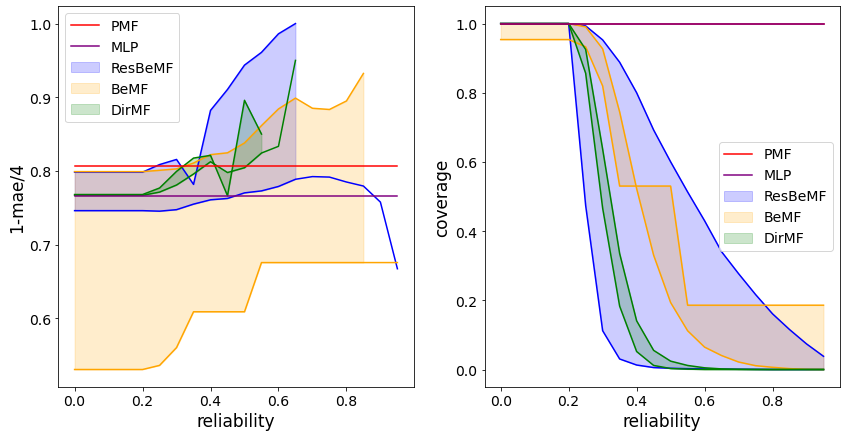

In [207]:
fig, axs = plt.subplots(1, 2, figsize=(14,7))

def plot_axis(df, name, ax):
    ax.set_xlabel('reliability', fontsize=17)
    ax.set_ylabel(name, fontsize=17)

    ax.tick_params(axis='both', which='major', labelsize=14)

    ax.plot(df['reliability'], df['ResBeMF_MAE'], c='blue')
    ax.plot(df['reliability'], df['ResBeMF_Coverage'], c='blue')
    ax.fill_between(df['reliability'], df['ResBeMF_MAE'], df['ResBeMF_Coverage'], color='blue', alpha=0.2, label='ResBeMF')

    ax.plot(df['reliability'], df['BeMF_MAE'], c='orange')
    ax.plot(df['reliability'], df['BeMF_Coverage'], c='orange')
    ax.fill_between(df['reliability'], df['BeMF_MAE'], df['BeMF_Coverage'], color='orange', alpha=0.2, label='BeMF')

    ax.plot(df['reliability'], df['DirMF_MAE'], c='green')
    ax.plot(df['reliability'], df['DirMF_Coverage'], c='green')
    ax.fill_between(df['reliability'], df['DirMF_MAE'], df['DirMF_Coverage'], color='green', alpha=0.2, label='DirMF')

    ax.plot(df['reliability'], df['PMF'], c='red', label='PMF')

    ax.plot(df['reliability'], df['MLP'], c='purple', label='MLP')

    ax.legend(fontsize=14)
    
plot_axis(mae_df, '1-mae/4', axs[0])
plot_axis(coverage_df, 'coverage', axs[1])
